# Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of event. We will generate data as in the demo on the github main page but we'll make it harder to find for the HMP algortihm by reducing the amplitude of the generating sources.

In [1]:
## Importing the package
import hsmm_mvpy as hmp

## Imports and code specific to the simulation (see tutorial 3 and 4 for real data)
import os
import numpy as np
from scipy.stats import gamma
from hsmm_mvpy import simulations
import matplotlib.pyplot as plt 
import seaborn as sns

cpus = 3 # For multiprocessing, usually a good idea to use multiple CPus as long as you have enough RAM

## Parameters for the simulations
frequency, amplitude = 10., .3e-6 #Frequency of the transition event and its amplitude in Volt
shape = 2#shape of the gamma distribution

#Storing electrode position, specific to the simulations
positions = simulations.simulation_positions()#Electrode position
sfreq = simulations.simulation_sfreq()#sampling freqency of the simulated data
resample_freq = 100#Resampling at 100Hz to make processing faster and less demanding
all_source_names = simulations.available_sources()#all brain sources you can play with
n_trials = 50 #Number of trials to simulate

# Randomly specify the transition events
n_events = 8
name_sources = np.random.choice(all_source_names,n_events+1, replace=False)#randomly pick source without replacement
times = np.array([20, 40, 80, 160, 320, 140, 70, 60, 60])/shape
#The means of the gamma distribution are here fixed, uncoment following line to have random stage duration
#times = np.random.uniform(25,300,n_events+1)/shape#randomly pick average times in millisecond between the events

sources = []
for source in range(len(name_sources)):
    sources.append([name_sources[source], frequency, amplitude, \
                      gamma(shape, scale=times[source])])

file = 'dataset_tutorial2' #Name of the file to save

#Simulating and recover information on electrode location and true time onset of the simulated events
files = simulations.simulate(sources, n_trials, cpus,file, overwrite=True, location=25)
generating_events = np.load(files[1])
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
random_source_times = np.reshape(np.diff(generating_events[:,0], prepend=0),(n_trials,number_of_sources+1))[:,1:]/(sfreq/resample_freq)#By-trial generated event times

#Reading the necessary info to read the EEG data
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}
resp_id = {'response':resp_trigger}
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

# Reading the data
eeg_dat = hmp.utils.read_mne_data(files[0], event_id, resp_id, sfreq=resample_freq, events_provided=events, verbose=False)
hmp_dat = hmp.utils.transform_data(eeg_dat, apply_standard=False, n_comp=number_of_sources-1)

/Users/Jelmer/miniconda3/envs/learning_swahili/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Simulating ./dataset_tutorial2_raw.fif


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Overwriting existing file.
Writing /Users/Jelmer/Work/Experimenten&Modellen/LearningSwahili/EEG_hmp/analysis_eeg/hsmm_mvpy/tutorials/dataset_tutorial2_raw.fif
Closing /Users/Jelmer/Work/Experimenten&Modellen/LearningSwahili/EEG_hmp/analysis_eeg/hsmm_mvpy/tutorials/dataset_tutorial2_raw.fif
[done]
./dataset_tutorial2_raw.fif simulated
Processing participant ./dataset_tutorial2_raw.fif's continuous eeg
Reading 0 ... 209097  =      0.000 ...   348.138 secs...
Downsampling to 100 Hz
50 trials were retained for participant ./dataset_tutorial2_raw.fif


HMP uses classes to instantiate fit of hmp models. Therefore before estimating a model one needs to declare an instance of the hmp class by specifying the data, the sampling frequency of the data as well as several parmeters such as the event width (in milliseconds) and how many CPU to use.

In [2]:
init = hmp.models.hmp(hmp_dat, sfreq=eeg_dat.sfreq, event_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
We can simply call the ```fit_single``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for 4 events. Now the expectation maximization algorithm to fit the model is in this case sensitive to the starting points given to the stage duration. By default, the ```fit_single``` method uses a starting point where all events are equally distributed between 0 and the mean RT.

Estimating 8 events model with 1 starting point(s)
Parameters estimated for 8 events model


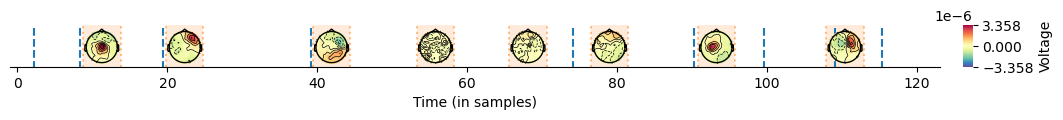

In [3]:
#Fitting
selected = init.fit_single(number_of_sources-1)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Now launching a single model without additional starting points is not a good idea as often the default starting values of the expectation maximization algorithm will end up in a local minima. We need to use more starting points and we developed several methods for that
 

## Random method


A better idea is to run a single model with several starting points and selecting the result with the best fit. This can be declared in the ```single_fit()``` function; hereby an example with 100 random starting points.

Estimating 8 events model with 100 starting point(s)


Parameters estimated for 8 events model


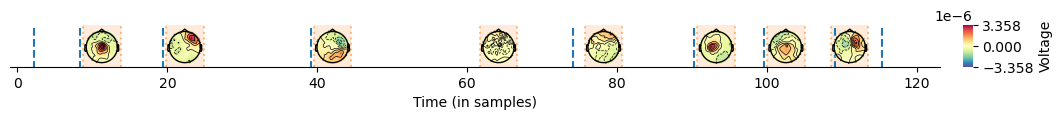

In [4]:
#NOTE: if you run this in VS code on a Mac in an interactive window, you might get strange behavior (running of previous processes) due to the multiprocessing. If so, set your multiprocessing start method to 'fork' (which is the default on Unix) by uncommenting the next two lines:
#import multiprocessing as mp
#mp.set_start_method("fork")

# Fitting
selected = init.fit_single(number_of_sources-1, method='random', starting_points=100)#function to fit an instance of a 4 events model
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

But, by definition, the starting points are random so inducing a lot of redundancy and also taking the risk that some points in the parameter space remain unexplored. However, in the example above one extra event is discovered correctly.

## Grid search 
In an effort to circumvent these limitations we designed a function called ```grid_search``` which basically decomposes the mean RT into a grid with points. After having defined the grid, the function then generates all possible combination of 
        _n_ event placements within this grid. It is faster than using random points (both should converge with enough starting points) but depending on the mean RT and the number 
        of events to look for, the number of combinations can be really large. For this reason we also need to specify a maximum number of starting points (note that this does no longer specify the number of models that we're fitting, only the max). The ```grid_search```function will then scale the grid according to the maximum starting points number requested.

Estimating 8 events model with 500 starting point(s)
Initial number of possibilities is 550339251858.
Given the number of max iterations = 500: fitting 165 models based on all 
 possibilities from grid search with a spacing of 8 samples and 13 points  
 and durations of [ 8. 16. 24. 32.].


Parameters estimated for 8 events model


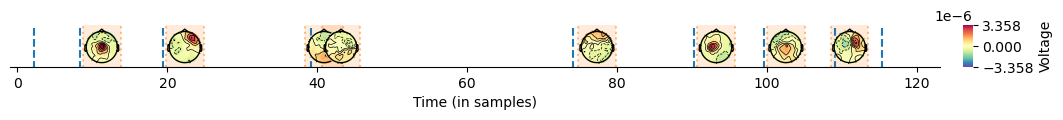

In [5]:
#Fitting
selected = init.fit_single(number_of_sources-1, method='grid', starting_points=500)#function to fit an instance of a 4 events model
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

This works well – although even here the first event is still misssed – but note how we needed to reduce the number of combinations by specifying ```starting_points=100```. The output shows us that the algorithm used a spacing of 8 samples between tested locations which could be suboptimal, even more so with a longer mean RT. Ideally we would like a method that looks for the likelihood of an event at every sample.

## Backward estimation

Both solutions above are not optimal. Especially if, for example, you are trying to fit a medium number of events for longer mean durations, it will generate too many possibilties for grid search (which then decreases precision in the grid) or requires too many random starting points. Therefore, a better solution than using random points is to first estimate a model with the maximal number of possible events (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if there location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```backward_estimation()``` function. This function first estimates the maximal model (defined based on the event width and the minimum reaction time), then estimates the max_event - 1 solution by iteratively removing one of the events and picking the next solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

In [6]:
%%time 
bests = init.backward_estimation()

Estimating all solutions for maximal number of events (14) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 13 number of events
Estimating all solutions for 12 number of events
Estimating all solutions for 11 number of events
Estimating all solutions for 10 number of events
Estimating all solutions for 9 number of events
Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
CPU times: user 1.32 s, sys: 713 ms, total: 2.03 s
Wall time: 31.6 s


Here we plot the resulting solutions going from the maximal possible number of events that fit into the minimum RT given a minimum duration of 25ms in this example. 

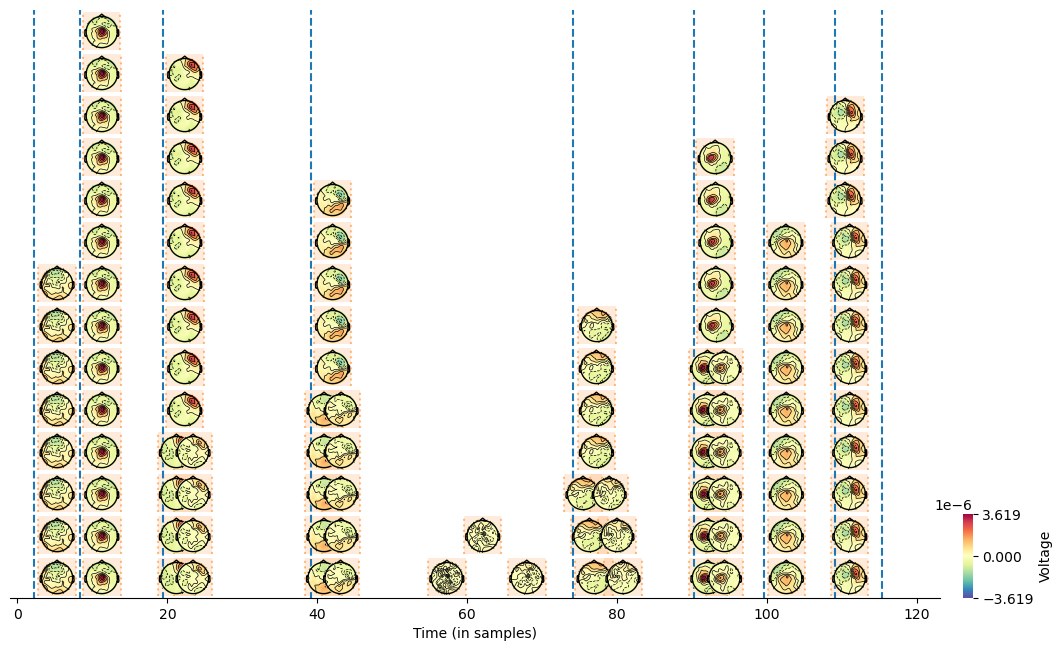

In [7]:
hmp.visu.plot_topo_timecourse(eeg_dat, bests, positions, init, sensors=False,
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

And from these solutions we can then select the number of events we orignally wanted to estimate (which is the correct solution):

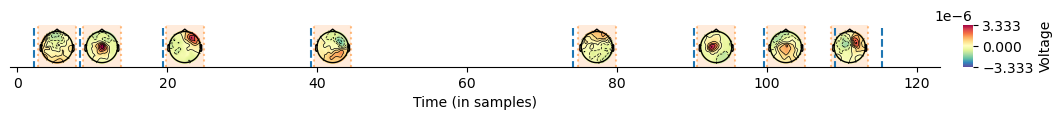

In [8]:
selected = bests.sel(n_events=number_of_sources-1)
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

The downside is that we are still unsure about whether we included all possible starting points in the mix. In addition, this method can be suboptimal with 1) long RTs and therefore a lot of events to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of events) and the mean RT (all possible locations of these events).

## Cumulative event fit

Instead of fitting an _n_ event model, this method fits a 1 event model (two stages) using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as an estimated event has at least one different voltage property (in PC space) than the previous one by a given ```threshold``` – indicating a different topology – the function fits an _n+1_ event model and uses the next samples in the RT for the following event.

In [9]:
estimates = init.fit(threshold=1, verbose=True)

 16%|█▌        | 18/115 [00:00<00:00, 104.16it/s]

Transition event 1 found around sample 4
Transition event 2 found around sample 10


154it [00:02, 169.96it/s]                        

Transition event 3 found around sample 101
Transition event 4 found around sample 110


162it [00:02, 59.43it/s] 

Estimating 4 events model
Parameters estimated for 4 events model


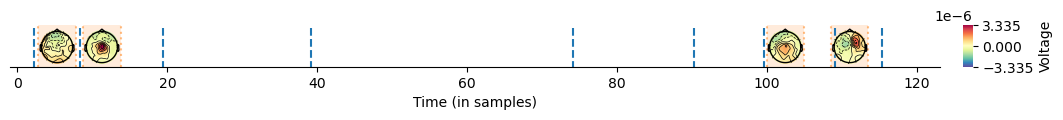

In [10]:
hmp.visu.plot_topo_timecourse(eeg_dat, estimates, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

One downside of this method is the use of a thresholding. A too high threshold will yield a 1 event/2 stages model or may return a subset of the actual events. A method remains to be found that can accomodate any dataset and set the threshold based on the dataset itself, but for now the only solution is to play around with several thresholds. For instance, here's the same analysis with a threshold of .18:

In [18]:
estimates = init.fit(threshold=.18, verbose=False)

178it [00:09, 19.76it/s]


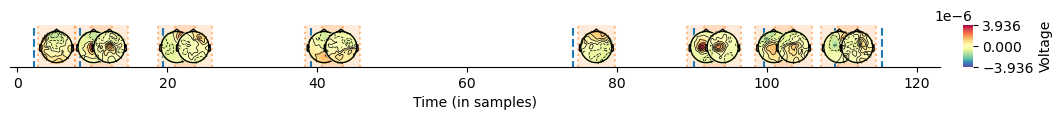

In [19]:
hmp.visu.plot_topo_timecourse(eeg_dat, estimates, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

Decreasing the threshold induced some confabulated events but the true events are recovered. We can combine this method and the backward estimation by using the 'lenient threshold' version and feed it to the backward estimation method for initial parameters (max_fit):

In [20]:
bests = init.backward_estimation(max_fit=estimates, min_events=3)#.We limit at 3 just for readabilty

Estimating all solutions for 13 number of events
Estimating all solutions for 12 number of events
Estimating all solutions for 11 number of events
Estimating all solutions for 10 number of events
Estimating all solutions for 9 number of events
Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events


Here we plot the resulting solutions going from the maximal number of events of the cumulative fit to four events.

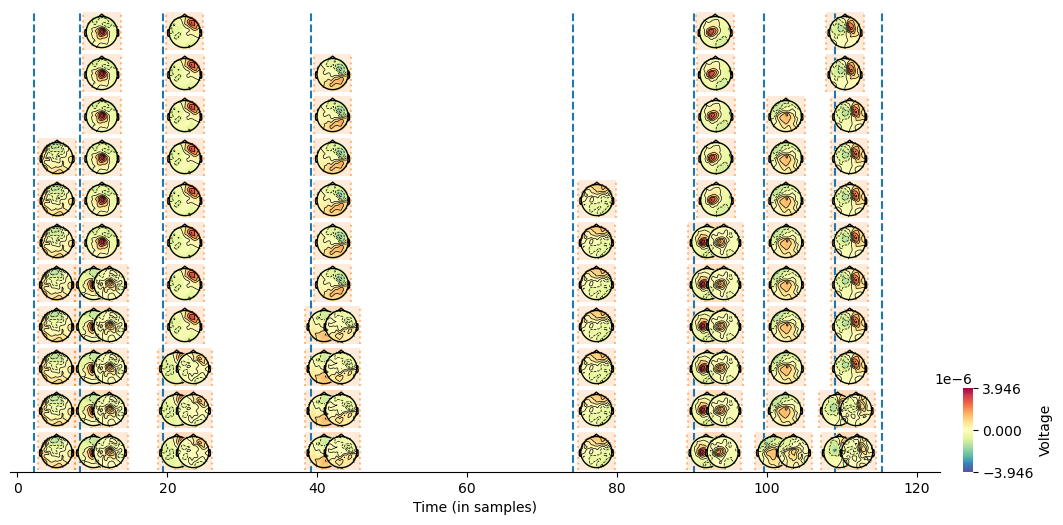

In [21]:
hmp.visu.plot_topo_timecourse(eeg_dat, bests, positions, init, sensors=False, ydim='n_events',
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

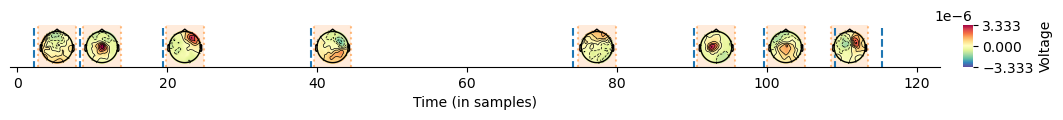

In [22]:
selected = bests.sel(n_events=number_of_sources-1)
hmp.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

# Data saving

Once finished we can save fitted models using the dedicated command

In [31]:
hmp.utils.save_fit(selected, 'selected.nc')

selected.nc saved


And load the same way

In [32]:
estimates = hmp.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [33]:
hmp.utils.save_eventprobs(selected.eventprobs, 'selected_eventprobs.nc')

Saved at selected_eventprobs.nc
